# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading Data

In [2]:
df=pd.read_csv('features_data.csv')
df['Label'] = df['Label'].replace({0: 'Tr.B', 1: 'IoT.M', 2: 'IoT.M', 3: 'IoT.M', 4: 'IoT.B', 5: 'Tr.M'})

In [3]:
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

df1=df[:1000000]

# Filter only benign data for training
benign_df = df1[df1['Label'].isin(['Tr.B', 'IoT.B'])]
malicious_df = df1[df1['Label'].isin(['Tr.M', 'IoT.M'])]

In [4]:
import pandas as pd

# Assuming the "Label" column contains categorical values before replacement
df1["Label"] = df1["Label"].astype(str)  # Ensure it's a string type

# Extract only IoT.B for training
train_df = df1[df1["Label"] == "IoT.B"]

# Convert labels to numerical values after filtering
df1["Label"] = df1["Label"].replace({'Tr.B': 0, 'IoT.B': 0, 'Tr.M': 1, 'IoT.M': 1})

# Ensure test_df contains all other cases (Tr.B, Tr.M, IoT.M)
test_df = df1.drop(train_df.index)  # Everything except IoT.B goes to testing

# Display the data split
print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)


Training Data Shape: (686829, 39)
Testing Data Shape: (313171, 39)


In [5]:
from collections import Counter
Counter(train_df['Label'])

Counter({'IoT.B': 686829})

In [6]:
from collections import Counter
Counter(test_df['Label'])

Counter({1: 257782, 0: 55389})

### Basic Statistics

In [7]:
df1.describe()

,Protocol,TCP,UDP,TTL,ACK,SYN,FIN,PSH,URG,RST,...,DstPortEntropy,AvgPacketNumber,SYNFrequency,ACKFrequency,TCPFrequency,UDPFrequency,MostFreqProtocol,PacketSizeVar,MostFreqPayloadSize,AvgPayloadSize
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,6.355020,0.967708,0.032280,87.651590,0.879704,0.156431,0.136618,0.311938,0.0,0.040237,...,1.764036,13726.268381,2360.396327,4552.047313,0.967696,0.032294,6.351738,28901.624259,106.651394,93.171477
std,1.944259,0.176775,0.176743,31.459127,0.325308,0.363264,0.343444,0.463285,0.0,0.196515,...,0.637971,52157.932190,18852.163904,27524.319281,0.175187,0.175164,1.935387,106344.646018,341.001219,238.990523
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,63.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.735359,111.000000,18.000000,98.000000,1.000000,0.000000,6.000000,327.579536,0.000000,7.617886
50%,6.000000,1.000000,0.000000,64.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.809496,132.000000,20.000000,119.000000,1.000000,0.000000,6.000000,527.055495,0.000000,9.655172
75%,6.000000,1.000000,0.000000,128.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,1.878353,160.000000,22.000000,143.000000,1.000000,0.000000,6.000000,756.821624,0.000000,12.139429
max,17.000000,1.000000,1.000000,255.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,...,2.987795,314719.000000,210601.000000,236709.000000,1.000000,0.999979,17.000000,523012.583540,1448.000000,1109.118248


### For anomaly detection, we only need genuine class of the data

Since we want the model to only learn and fit on normal data, we only use the `genuine` class. This is to ensure that when an abnormal input is given to the model, its reconstruction error will be higher than that of a normal input. For testing of the model, samples from both the classes will be used.

In [8]:
X = train_df.drop(['Label'], axis=1)
y = train_df['Label']

X1 = test_df.drop(['Label'], axis=1)
y_test = test_df['Label']

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)
X_test = scaler.transform(X1)



print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (686829, 38)
Testing Data Shape: (313171, 38)


In [9]:
import time
import psutil
import os
import tensorflow as tf

# Set up your training data (example)
# X_train, X_test should be defined before this step

# Function to track resource usage
def track_resources():
    # Get the current process ID
    process = psutil.Process(os.getpid())
    
    # Get CPU usage as a percentage
    cpu_usage = process.cpu_percent(interval=1)  # CPU percentage for the last second
    
    # Get memory usage in MB
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    
    return cpu_usage, memory_usage

# Define a custom callback to track resource usage during training
class ResourceTrackingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        cpu, memory = track_resources()
        # Display CPU and Memory usage rounded to 5 decimal places
        print(f"Epoch {epoch+1}: CPU Usage: {cpu:.5f}% | Memory Usage: {memory:.5f} MB")

# Update the track_resources function
def track_resources():
    # Get the current process ID
    process = psutil.Process(os.getpid())
    
    # Get CPU usage as a percentage, increasing interval for better accuracy
    cpu_usage = psutil.cpu_percent(interval=2)  # Set a longer interval
    
    # Get memory usage in MB
    memory_usage = process.memory_info().rss / (1024 * 1024)  # Memory in MB
    
    return cpu_usage, memory_usage

# DNN Model Building - Autoencoder

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout


# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = input_dim // 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(encoding_dim // 2, activation="relu")(encoded)

decoded = Dense(encoding_dim // 2, activation="relu")(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")


autoencoder.compile(loss='mae', optimizer=Adam())

# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")

Epoch 1/100
Epoch 1: CPU Usage: 6.90000% | Memory Usage: 1417.10938 MB
5362/5362 - 11s - 2ms/step - loss: 0.0641 - val_loss: 43.5676
Epoch 2/100
Epoch 2: CPU Usage: 19.10000% | Memory Usage: 1417.18750 MB
5362/5362 - 9s - 2ms/step - loss: 0.0412 - val_loss: 43.5840
Epoch 3/100
Epoch 3: CPU Usage: 15.00000% | Memory Usage: 1417.25391 MB
5362/5362 - 11s - 2ms/step - loss: 0.0405 - val_loss: 43.5732
Epoch 4/100
Epoch 4: CPU Usage: 11.40000% | Memory Usage: 1417.28125 MB
5362/5362 - 11s - 2ms/step - loss: 0.0404 - val_loss: 43.5407
Epoch 5/100
Epoch 5: CPU Usage: 8.50000% | Memory Usage: 1417.29297 MB
5362/5362 - 11s - 2ms/step - loss: 0.0375 - val_loss: 43.5530
Epoch 6/100
Epoch 6: CPU Usage: 11.90000% | Memory Usage: 1417.29297 MB
5362/5362 - 11s - 2ms/step - loss: 0.0371 - val_loss: 43.4975
Epoch 7/100
Epoch 7: CPU Usage: 11.20000% | Memory Usage: 1417.37109 MB
5362/5362 - 10s - 2ms/step - loss: 0.0370 - val_loss: 43.5753
Epoch 8/100
Epoch 8: CPU Usage: 9.00000% | Memory Usage: 1417.578

reconstruction_error tf.Tensor(
[  0.14148133   0.1676037  132.803757   ...   0.18683032   0.17142959
  55.9946691 ], shape=(313669,), dtype=float64)
        error  y_true
0    0.141481       1
1    0.167604       1
2  132.803757       1
3    0.164565       1
4   15.731612       0
Threshold: 0.0064	Accuracy: 0.824		Precision: 0.412	Recall Score: 0.500
Threshold: 0.1547	Accuracy: 0.724		Precision: 0.402	Recall Score: 0.439
Threshold: 0.1610	Accuracy: 0.624		Precision: 0.390	Recall Score: 0.379
Threshold: 0.1694	Accuracy: 0.524		Precision: 0.375	Recall Score: 0.318
Threshold: 0.1850	Accuracy: 0.424		Precision: 0.354	Recall Score: 0.258
Threshold: 0.1928	Accuracy: 0.324		Precision: 0.324	Recall Score: 0.197
Threshold: 13.3074	Accuracy: 0.250		Precision: 0.308	Recall Score: 0.181
Threshold: 19.0137	Accuracy: 0.350		Precision: 0.476	Recall Score: 0.466
Threshold: 48.6381	Accuracy: 0.367		Precision: 0.607	Recall Score: 0.615
Threshold: 132.8038	Accuracy: 0.275		Precision: 0.597	Recall Score:

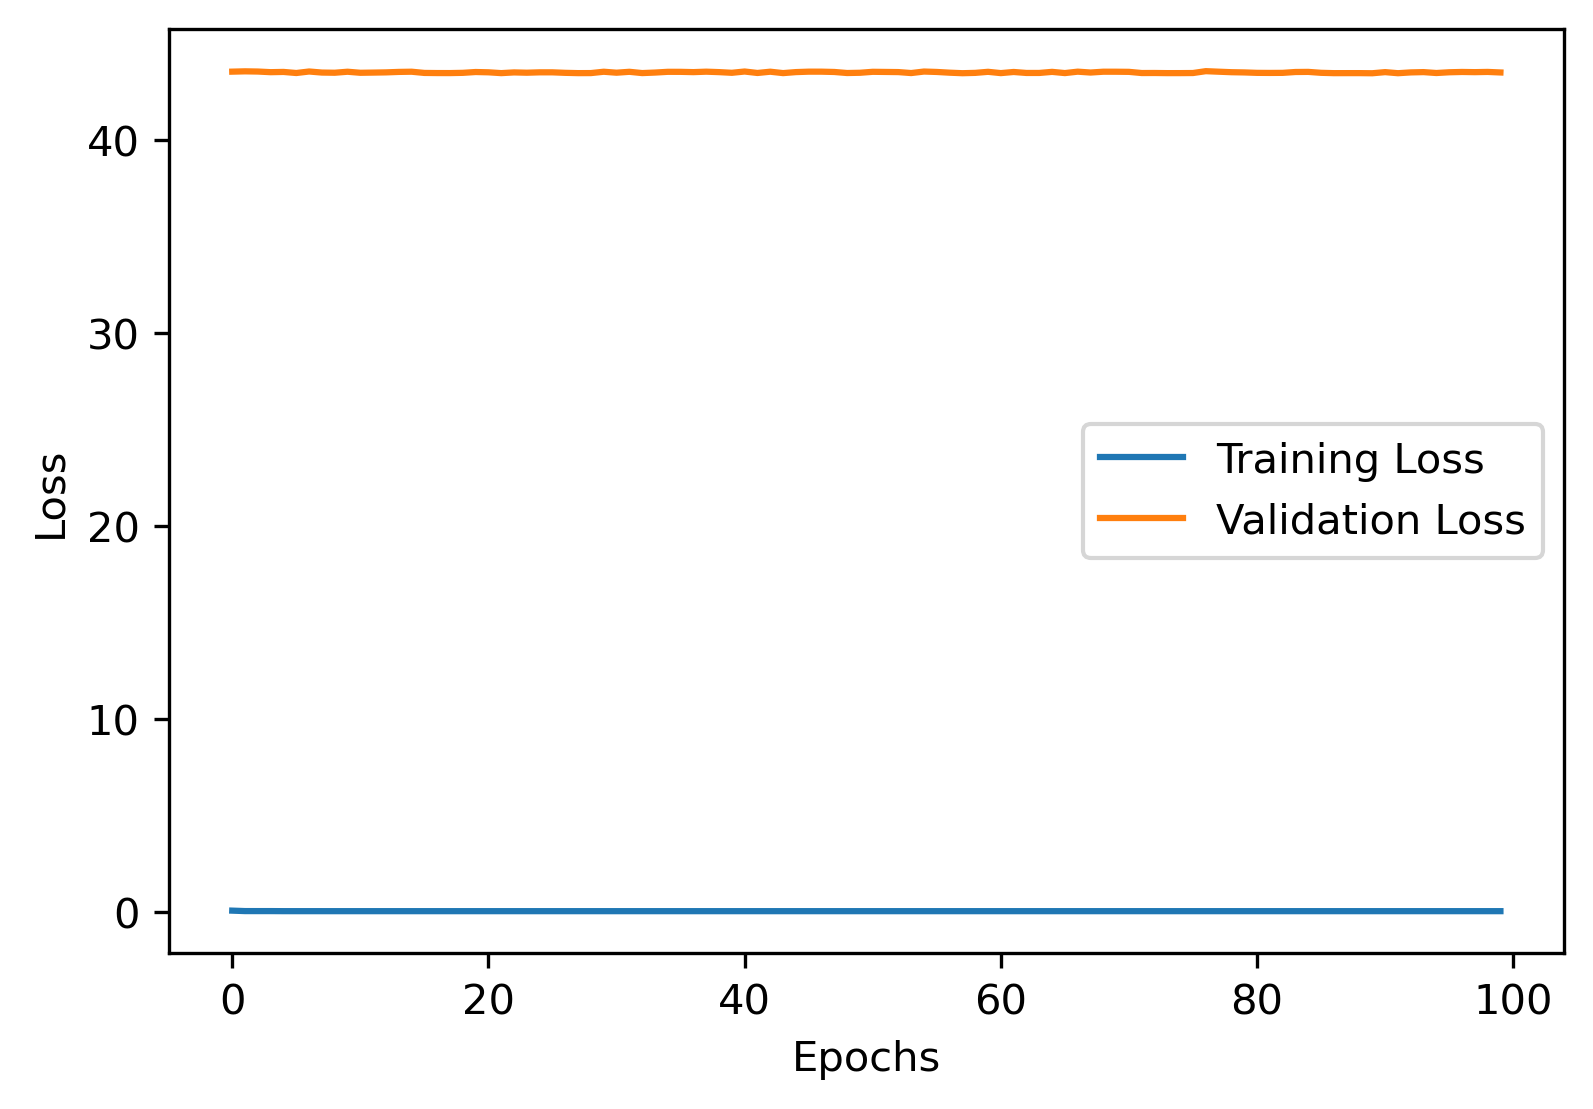

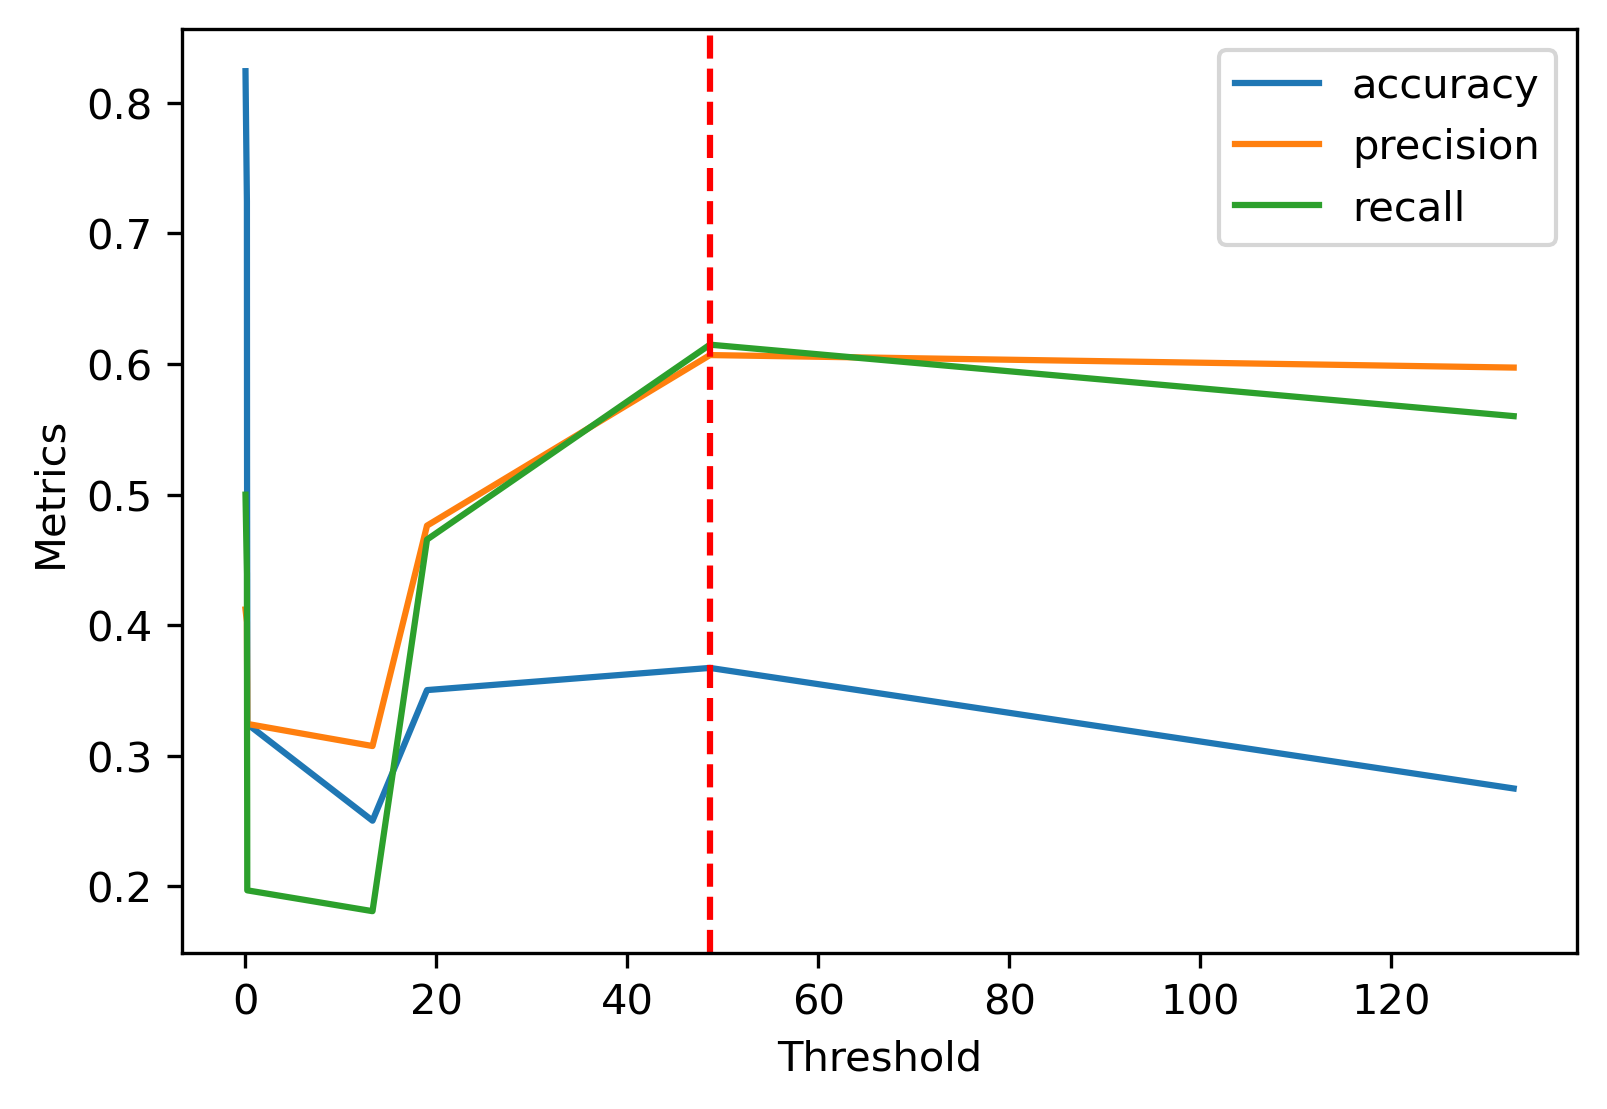

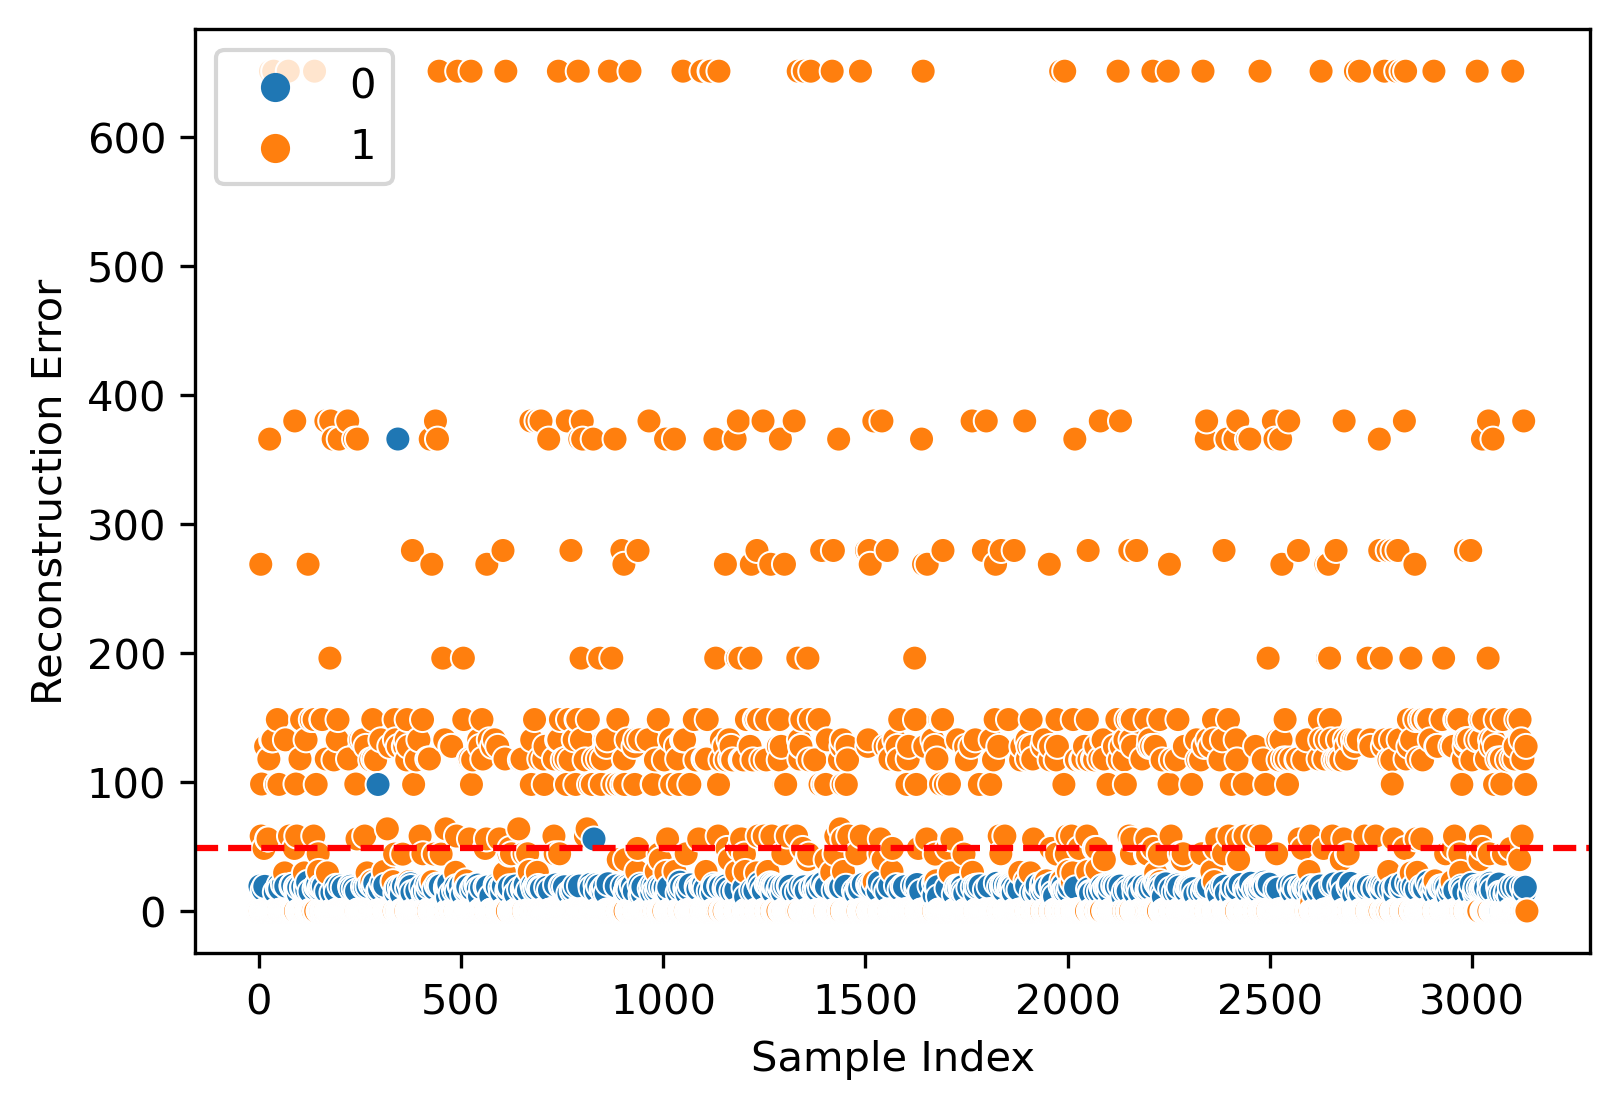

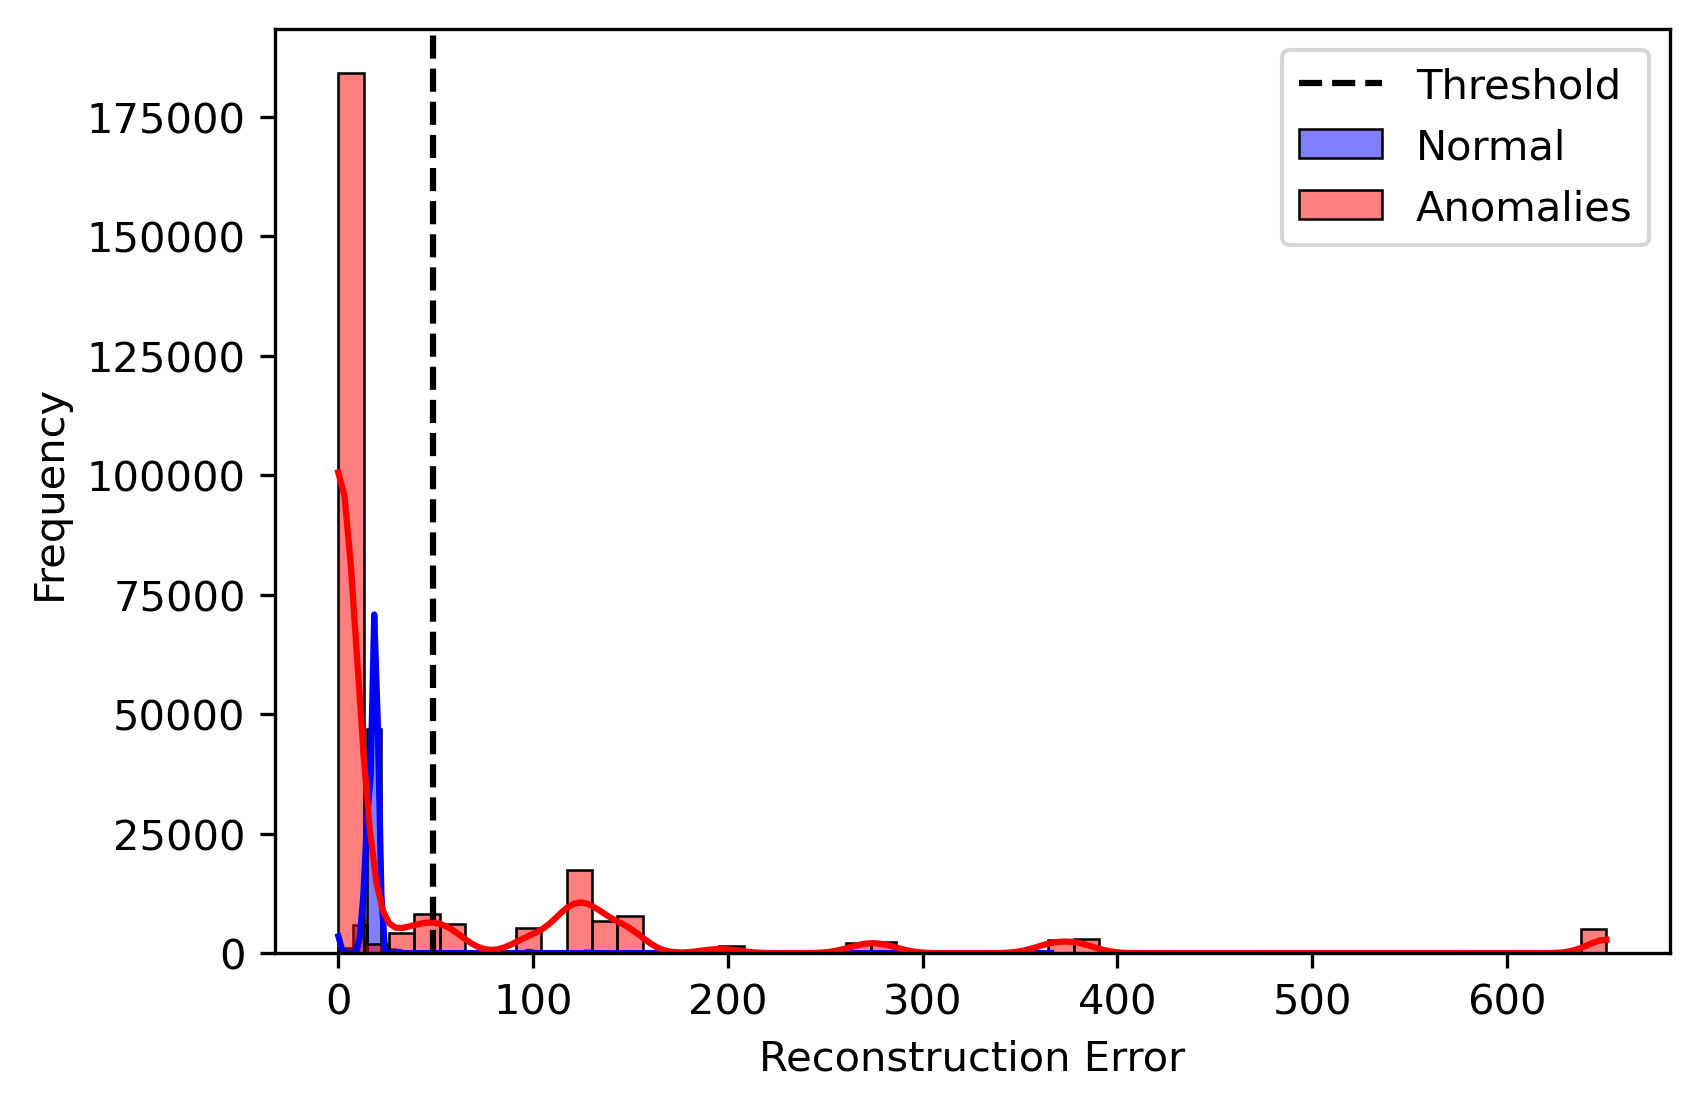

In [30]:
plt.figure(figsize=(6,4),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('DNNIoT.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(6,4),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.legend()
plt.savefig('DNNIoT_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(6,4),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.savefig('DNNIoT_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(6,4),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('DNNIoT_Reconst.jpg')


# 2 DNN Model

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



# Define the Residual Autoencoder model
def build_residual_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder layers with residual connections
    encoded = Dense(encoding_dim, activation="relu")(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    skip_connection = Dense(encoding_dim // 2, activation="relu")(encoded)

    encoded = Dense(encoding_dim // 2, activation="relu")(skip_connection)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    # Decoder layers with residual connections
    decoded = Dense(encoding_dim // 2, activation="relu")(encoded)
    decoded = Add()([decoded, skip_connection])  # Adding skip connection here
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer="adam", loss="mse")
    
    return autoencoder

# Build and train the model
input_dim = X_train.shape[1]
encoding_dim = input_dim // 2
autoencoder = build_residual_autoencoder(input_dim, encoding_dim)

# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")


Epoch 1/100
Epoch 1: CPU Usage: 9.10000% | Memory Usage: 1958.30078 MB
5362/5362 - 13s - 2ms/step - loss: 0.0146 - val_loss: 188962.6562
Epoch 2/100
Epoch 2: CPU Usage: 9.80000% | Memory Usage: 1958.36328 MB
5362/5362 - 11s - 2ms/step - loss: 0.0049 - val_loss: 188990.5625
Epoch 3/100
Epoch 3: CPU Usage: 24.90000% | Memory Usage: 1958.39062 MB
5362/5362 - 13s - 2ms/step - loss: 0.0040 - val_loss: 188944.7656
Epoch 4/100
Epoch 4: CPU Usage: 28.60000% | Memory Usage: 1958.44531 MB
5362/5362 - 15s - 3ms/step - loss: 0.0037 - val_loss: 188959.9375
Epoch 5/100
Epoch 5: CPU Usage: 22.20000% | Memory Usage: 1958.45312 MB
5362/5362 - 15s - 3ms/step - loss: 0.0036 - val_loss: 188959.8750
Epoch 6/100
Epoch 6: CPU Usage: 26.00000% | Memory Usage: 1958.45703 MB
5362/5362 - 14s - 3ms/step - loss: 0.0035 - val_loss: 188971.3906
Epoch 7/100
Epoch 7: CPU Usage: 23.80000% | Memory Usage: 1958.44922 MB
5362/5362 - 16s - 3ms/step - loss: 0.0035 - val_loss: 188961.7812
Epoch 8/100
Epoch 8: CPU Usage: 23.3

reconstruction_error tf.Tensor(
[  0.13519018   0.14801547 132.95416889 ...   0.18984459   0.17585429
  56.3211583 ], shape=(313669,), dtype=float64)
        error  y_true
0    0.135190       1
1    0.148015       1
2  132.954169       1
3    0.141019       1
4   15.486081       0
Threshold: 0.0072	Accuracy: 0.824		Precision: 0.412	Recall Score: 0.500
Threshold: 0.1444	Accuracy: 0.727		Precision: 0.409	Recall Score: 0.444
Threshold: 0.1504	Accuracy: 0.627		Precision: 0.395	Recall Score: 0.384
Threshold: 0.1564	Accuracy: 0.527		Precision: 0.378	Recall Score: 0.323
Threshold: 0.1648	Accuracy: 0.428		Precision: 0.357	Recall Score: 0.264
Threshold: 0.1789	Accuracy: 0.329		Precision: 0.329	Recall Score: 0.204
Threshold: 13.1294	Accuracy: 0.250		Precision: 0.308	Recall Score: 0.181
Threshold: 18.8574	Accuracy: 0.350		Precision: 0.476	Recall Score: 0.466
Threshold: 48.8166	Accuracy: 0.368		Precision: 0.607	Recall Score: 0.615
Threshold: 132.9542	Accuracy: 0.256		Precision: 0.595	Recall Score:

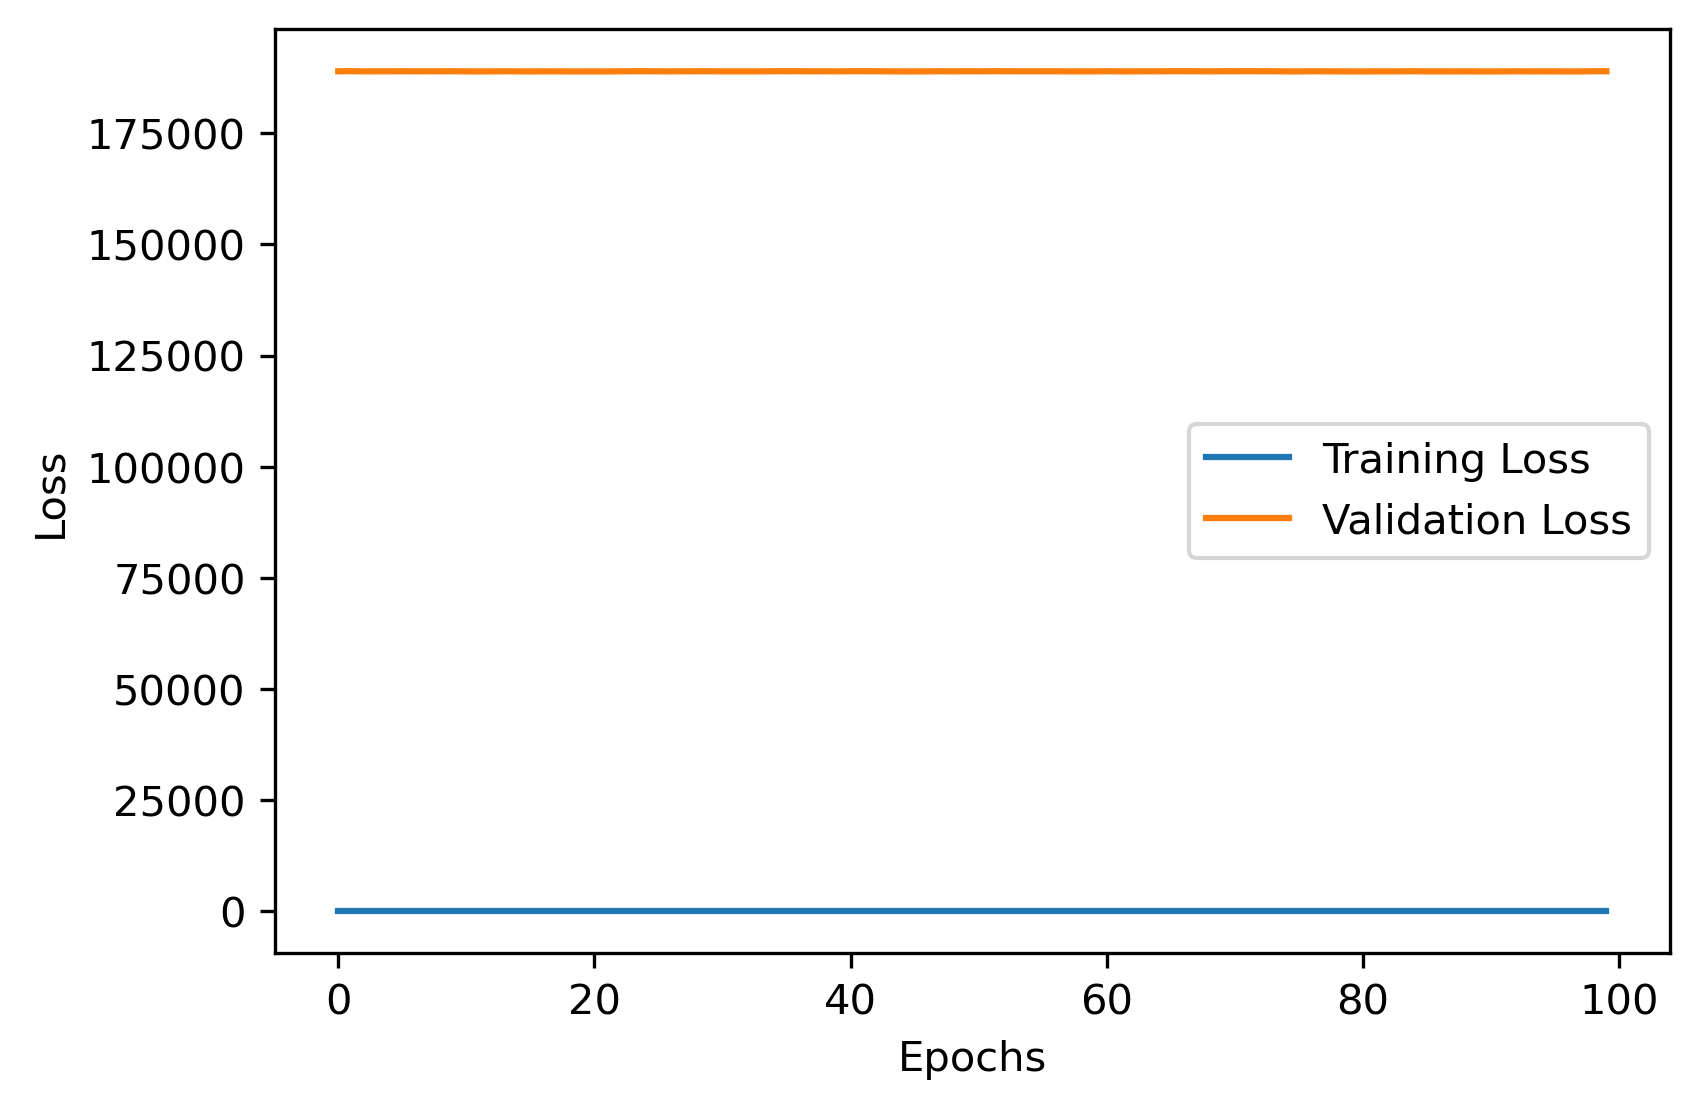

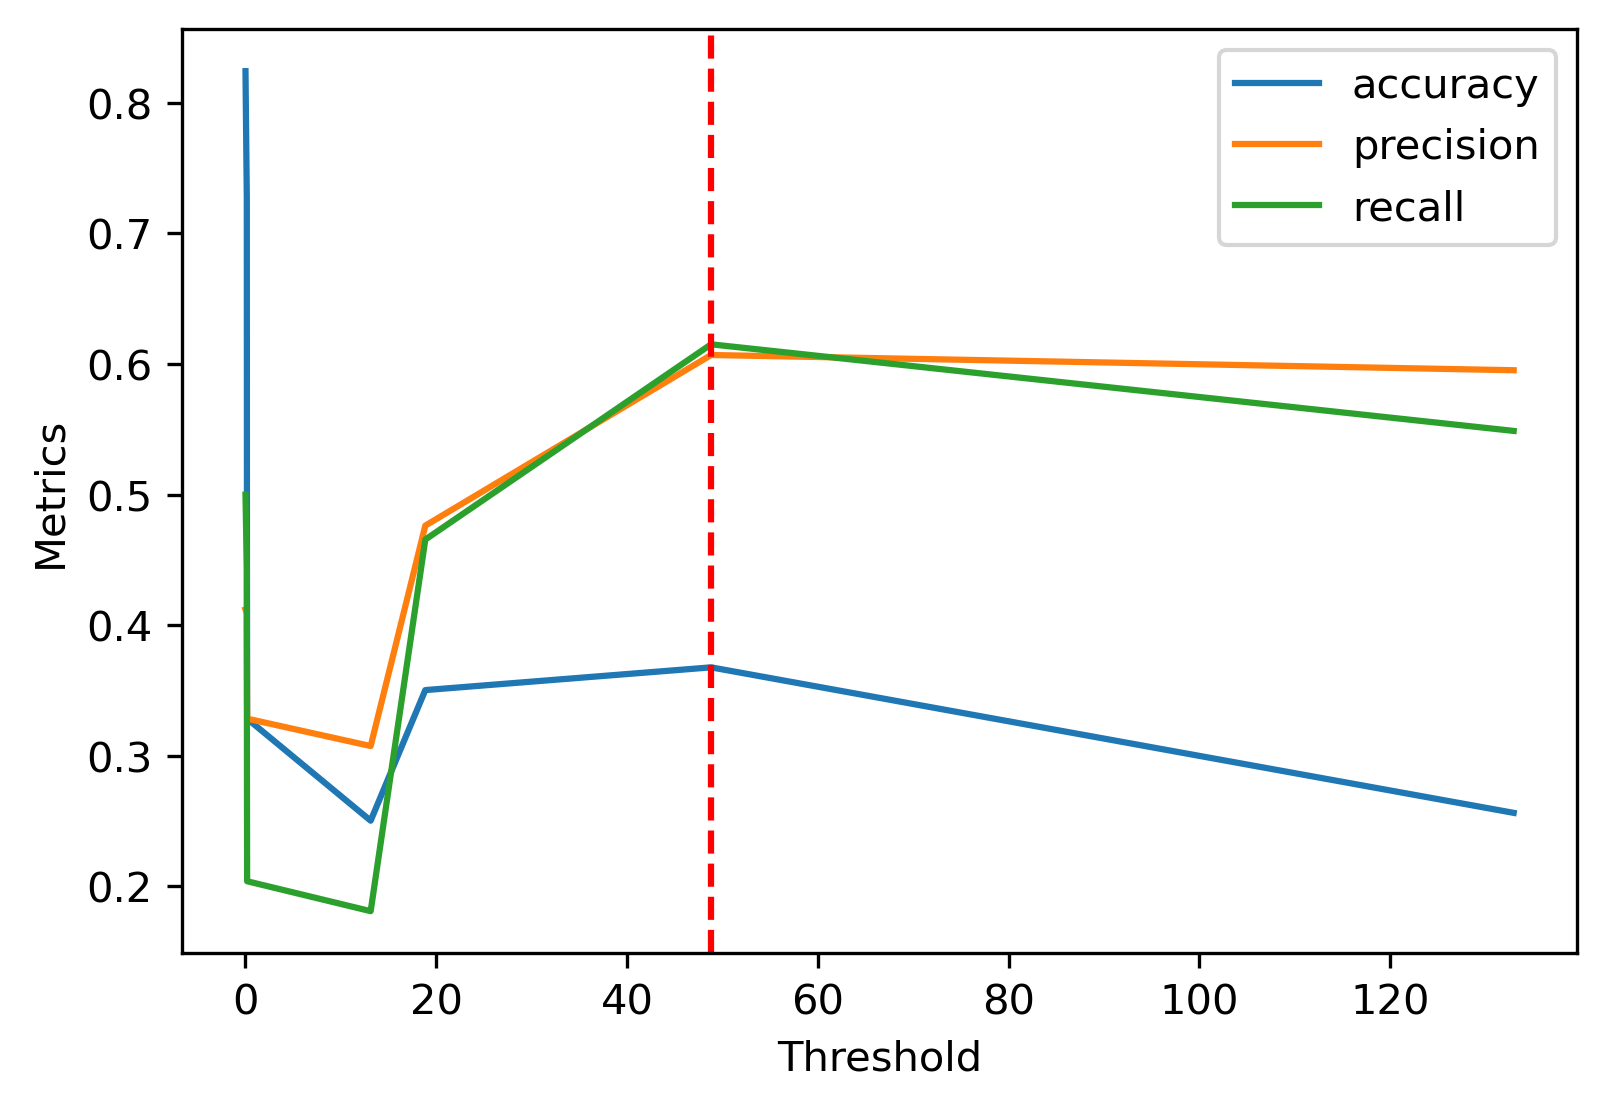

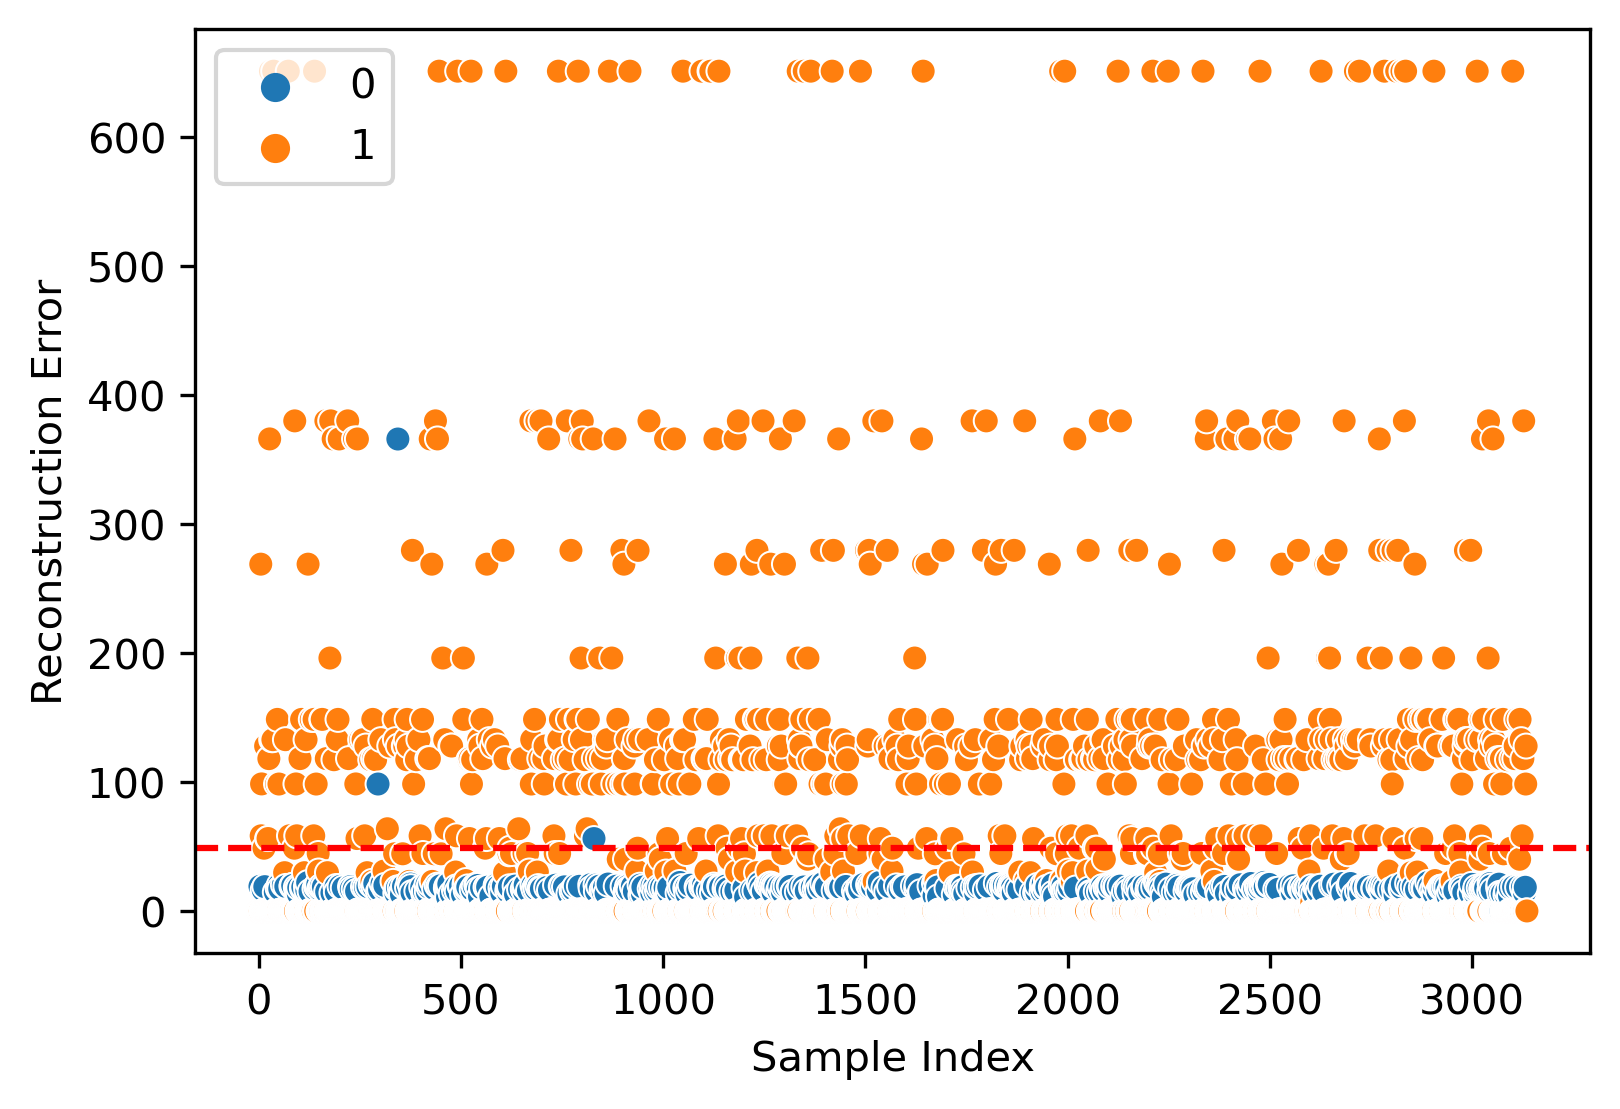

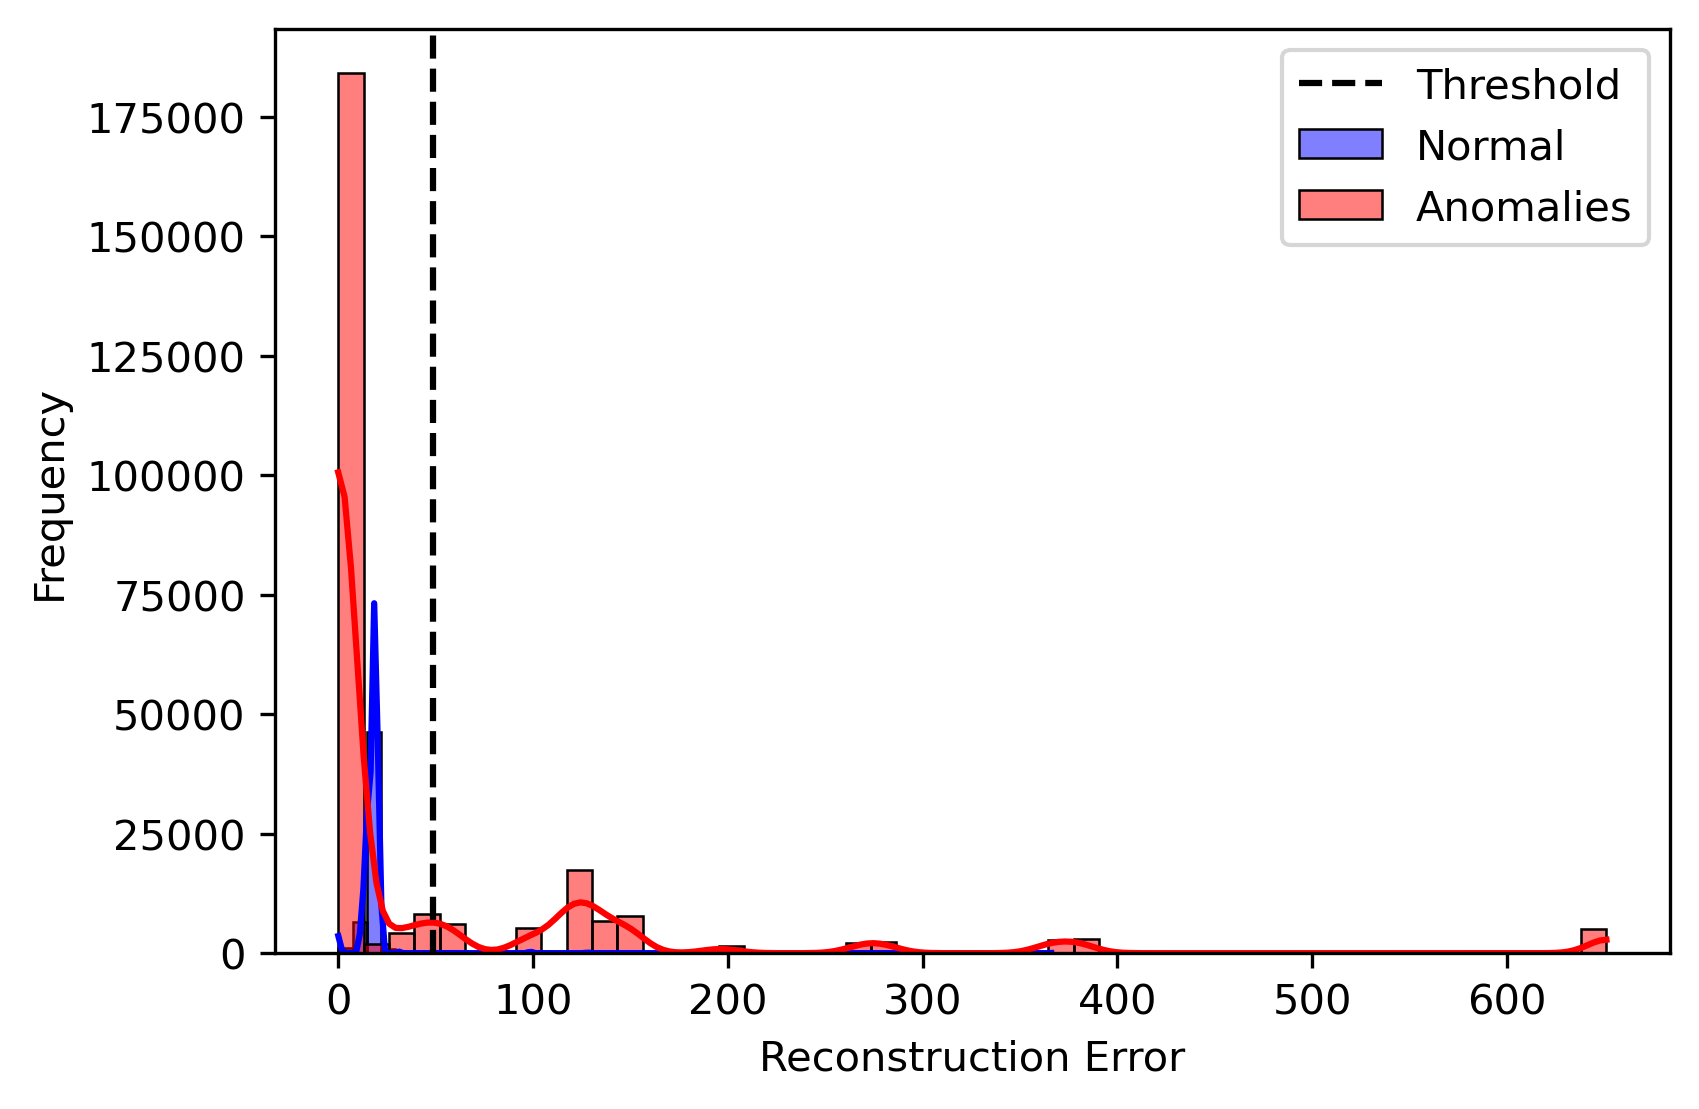

In [32]:
plt.figure(figsize=(6,4),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('2DNNIoT.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(6,4),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.legend()
plt.savefig('2DNNIoT_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(6,4),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.savefig('2DNNIoT_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(6,4),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('2DNNIoT_Reconst.jpg')


# Conv1D Autoencoder

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Cropping1D
from tensorflow.keras.optimizers import Adam

# Define the CNN-based Autoencoder for 1D data
def create_cnn_autoencoder_1d(input_shape):
    # Encoder
    input_layer = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    
    # Latent space
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    
    # Decoder
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
    
    # Crop the output to match the input shape
    x = Cropping1D(cropping=(1, 1))(x)  # Adjust cropping as needed
    output_layer = x
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Input data shape
input_shape = (38, 1)  # 38 features with 1 channel

# Create the model
autoencoder = create_cnn_autoencoder_1d(input_shape)

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary of the model
autoencoder.summary()


# Track start time
start_time = time.time()


# Initialize the ResourceTrackingCallback
resource_callback = ResourceTrackingCallback()

# Fit model with the custom callback to track resources
history = autoencoder.fit(
    X_train, X_train,
    epochs=100, 
    batch_size=128,
    validation_data=(X_test, X_test),
    shuffle=True,
    verbose=2,  # Suppress training progress output
    callbacks=[resource_callback]  # Include the resource tracking callback
)

# End time after training
end_time = time.time()
training_time = end_time - start_time

print(f"\nTraining completed in {training_time:.2f} seconds.")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 38, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 38, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 19, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 10, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 40, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 40, 1)          │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 38, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,953 (242.00 KB)

 Trainable params: 61,953 (242.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
Epoch 1: CPU Usage: 51.10000% | Memory Usage: 7482.77344 MB
5366/5366 - 95s - 18ms/step - loss: 0.0017 - val_loss: 191203.3281
Epoch 2/100
Epoch 2: CPU Usage: 24.70000% | Memory Usage: 7483.71484 MB
5366/5366 - 86s - 16ms/step - loss: 4.9297e-05 - val_loss: 191203.0625
Epoch 3/100
Epoch 3: CPU Usage: 44.50000% | Memory Usage: 7484.46094 MB
5366/5366 - 86s - 16ms/step - loss: 2.9421e-05 - val_loss: 191202.9219
Epoch 4/100
Epoch 4: CPU Usage: 37.30000% | Memory Usage: 7484.67188 MB
5366/5366 - 83s - 16ms/step - loss: 2.1818e-05 - val_loss: 191201.4844
Epoch 5/100
Epoch 5: CPU Usage: 46.50000% | Memory Usage: 7485.45703 MB
5366/5366 - 84s - 16ms/step - loss: 1.7497e-05 - val_loss: 191203.0312
Epoch 6/100
Epoch 6: CPU Usage: 44.30000% | Memory Usage: 7485.51953 MB
5366/5366 - 84s - 16ms/step - loss: 1.4294e-05 - val_loss: 191202.1719
Epoch 7/100
Epoch 7: CPU Usage: 40.50000% | Memory Usage: 7486.68750 MB
5366/5366 - 86s - 16ms/step - loss: 1.1703e-05 - val_loss: 191202.7969
Epo

reconstruction_error tf.Tensor([0.0273184  0.27430909 0.26864726 ... 0.28934433 0.25984274 0.25212512], shape=(313171,), dtype=float64)
        error  y_true
0    0.027318       1
1    0.274309       1
2    0.268647       1
3    0.250493       1
4  148.337195       1
Threshold: 0.0005	Accuracy: 0.823		Precision: 0.412	Recall Score: 0.500
Threshold: 0.2531	Accuracy: 0.730		Precision: 0.422	Recall Score: 0.452
Threshold: 0.2589	Accuracy: 0.630		Precision: 0.401	Recall Score: 0.391
Threshold: 0.2638	Accuracy: 0.530		Precision: 0.382	Recall Score: 0.330
Threshold: 0.2690	Accuracy: 0.430		Precision: 0.360	Recall Score: 0.269
Threshold: 0.2758	Accuracy: 0.330		Precision: 0.330	Recall Score: 0.209
Threshold: 13.0418	Accuracy: 0.249		Precision: 0.306	Recall Score: 0.180
Threshold: 18.8992	Accuracy: 0.349		Precision: 0.474	Recall Score: 0.463
Threshold: 44.3648	Accuracy: 0.375		Precision: 0.609	Recall Score: 0.619
Threshold: 132.6239	Accuracy: 0.256		Precision: 0.595	Recall Score: 0.548
Thresho

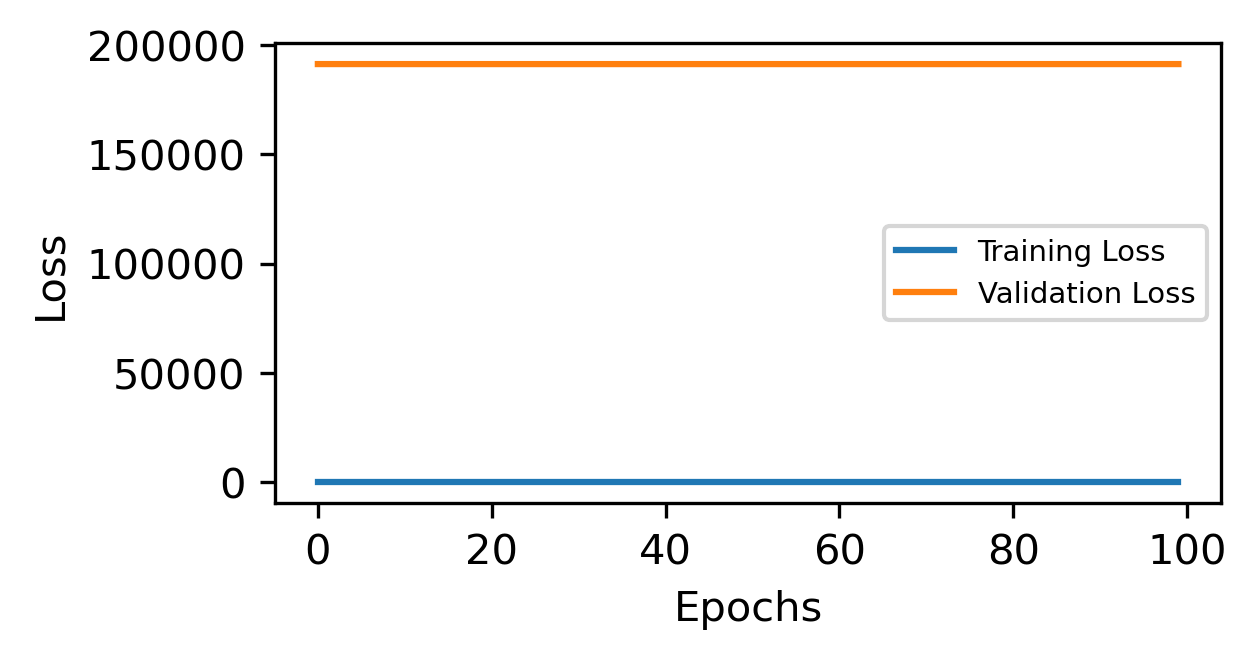

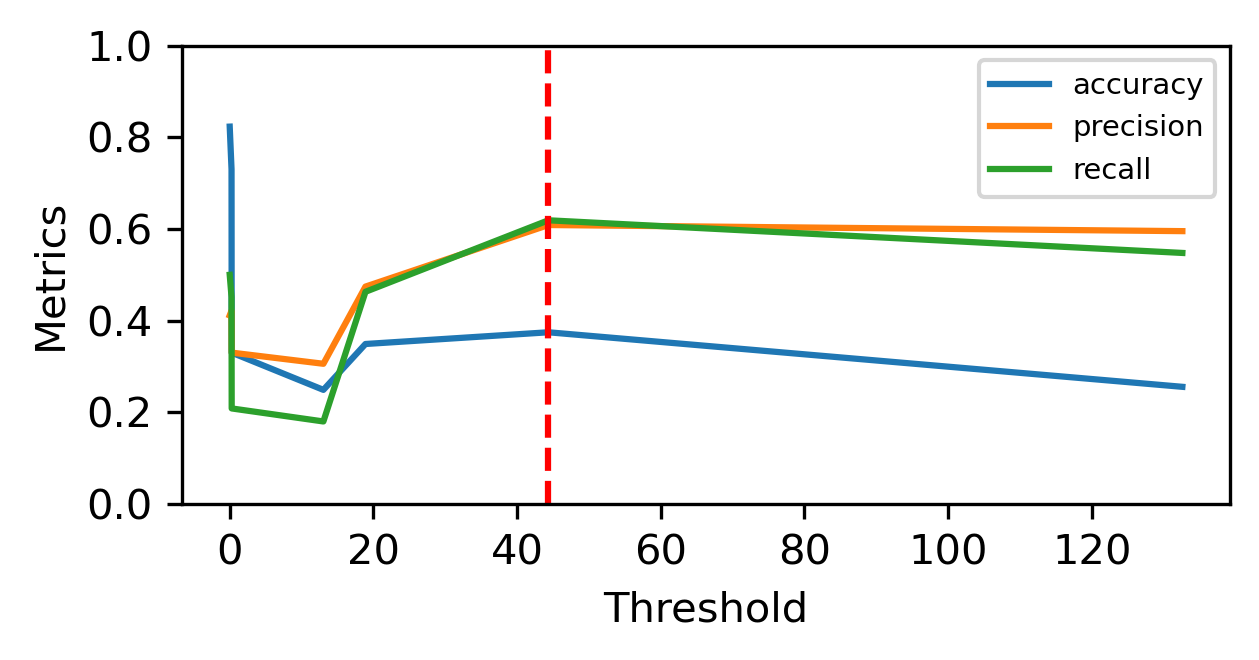

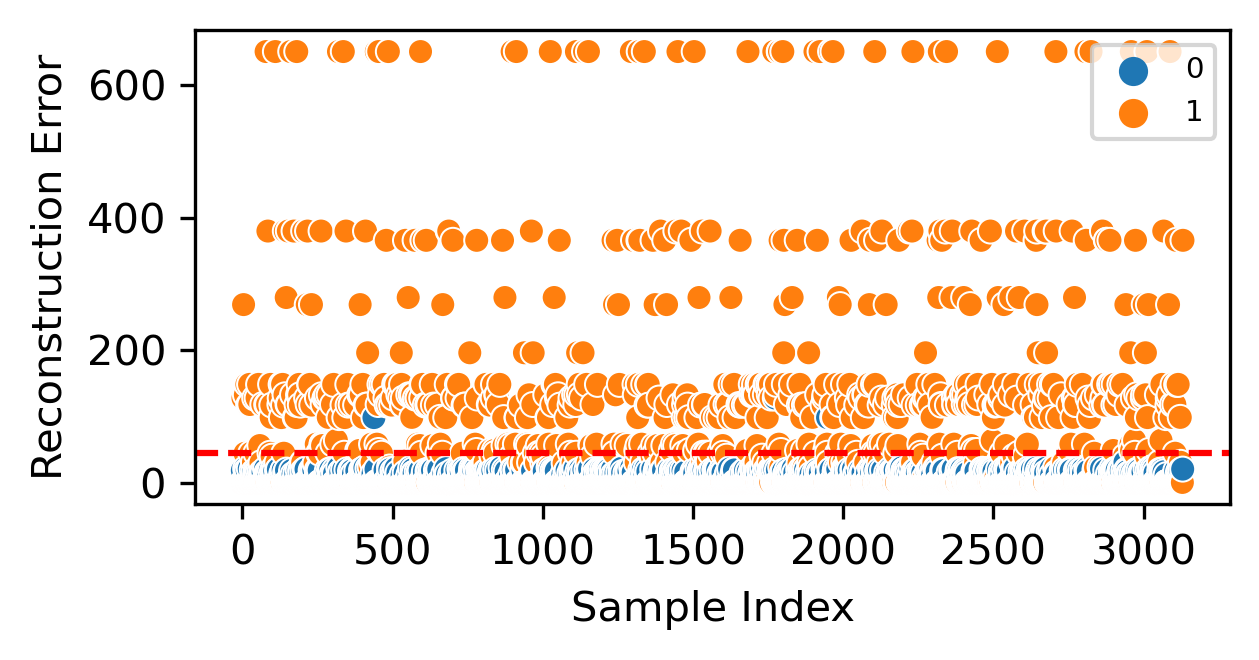

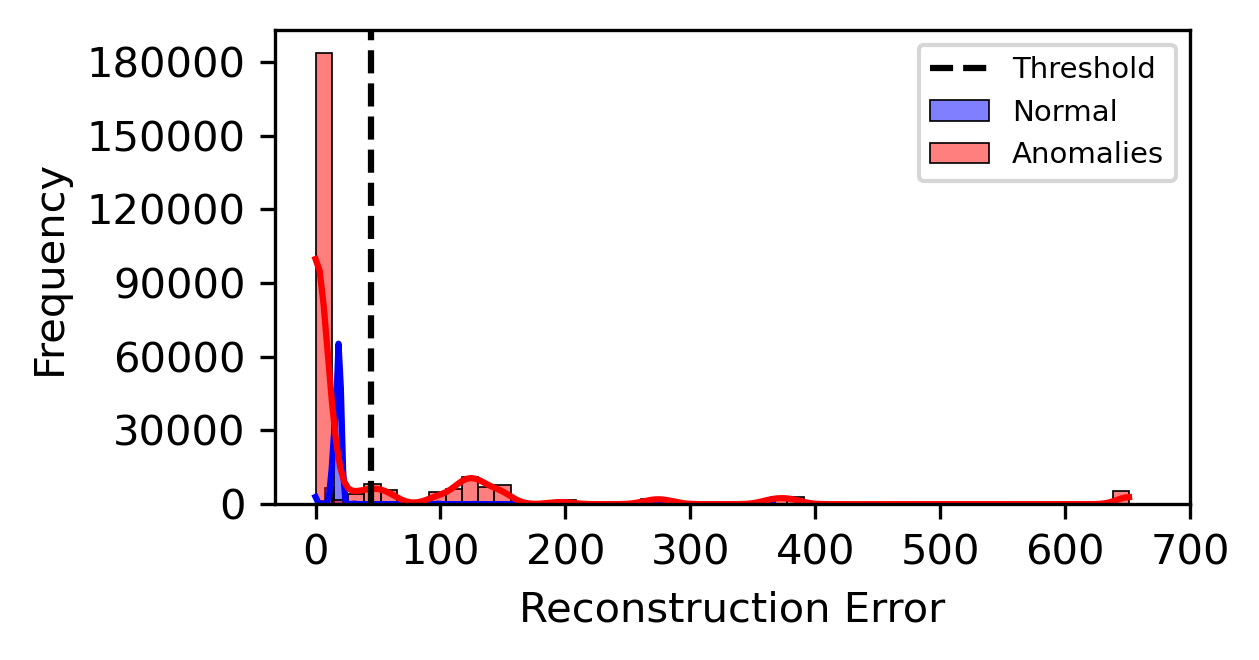

In [20]:
plt.figure(figsize=(4,2),dpi=300)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize = 7)
plt.tight_layout()
plt.tight_layout(pad=0)
plt.savefig('con1dIoT.jpg')



reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)
print('reconstruction_error',reconstruction_error)

recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)

print(recons_df.head())


def thresholdTuning(df, iterations):
    
    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']
        
        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)
        
        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")
        
    return pd.DataFrame(thresh_df)
        
thresh_df = thresholdTuning(recons_df, 10)

threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")


plt.figure(figsize=(4,2),dpi=300)
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.yticks(np.arange(0, 1.2, 0.2))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dIoT_Threshold.jpg')


temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(4,2),dpi=300)
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.yticks(np.arange(0, 800, 200))  # Corrected method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dIoT_Error.jpg')

recons_df['y_pred'] = recons_df['error'] > threshold
print(classification_report(recons_df['y_true'],recons_df['y_pred']))
print(confusion_matrix(recons_df['y_true'],recons_df['y_pred']))

print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

plt.figure(figsize=(4,2),dpi=300)
sns.histplot(reconstruction_error[y_test == 0], bins=50, color='blue', label='Normal', kde=True)
sns.histplot(reconstruction_error[y_test == 1], bins=50, color='red', label='Anomalies', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 750, 100))  # Corrected method
plt.yticks(range(0, 190000, 30000))  # Correct method
plt.legend(fontsize = 7)
plt.tight_layout(pad=0)
plt.savefig('con1dIoT_Reconst.jpg')
